In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import pyodbc
import seaborn as sns
import plotly.express as px

In [4]:
order_item_refunds = pd.read_csv("D:/Portfolio/E-Commerce/order_item_refunds.csv")
website_sessions = pd.read_csv("D:/Portfolio/E-Commerce/website_sessions.csv")
website_pageviews = pd.read_csv("D:/Portfolio/E-Commerce/website_pageviews.csv")
orders = pd.read_csv("D:/Portfolio/E-Commerce/orders.csv")
order_items = pd.read_csv("D:/Portfolio/E-Commerce/order_items.csv")
print("Done")

Done


In [40]:
print("Missing values per column:")
print(order_item_refunds.isna().sum().sort_values(ascending=False))
print(website_sessions.isna().sum().sort_values(ascending=False))
print(website_pageviews.isna().sum().sort_values(ascending=False))
print(orders.isna().sum().sort_values(ascending=False))
print(order_items.isna().sum().sort_values(ascending=False))

Missing values per column:
order_item_refund_id    0
created_at              0
order_item_id           0
order_id                0
refund_amount_usd       0
dtype: int64
utm_source            83328
utm_campaign          83328
utm_content           83328
http_referer          39917
website_session_id        0
created_at                0
user_id                   0
is_repeat_session         0
device_type               0
dtype: int64
website_pageview_id    0
created_at             0
website_session_id     0
pageview_url           0
dtype: int64
order_id              0
created_at            0
website_session_id    0
user_id               0
primary_product_id    0
items_purchased       0
price_usd             0
cogs_usd              0
dtype: int64
order_item_id      0
created_at         0
order_id           0
product_id         0
is_primary_item    0
price_usd          0
cogs_usd           0
dtype: int64


Các bảng hầu hết đều không có missing value. 
Các cột utm_source, utm_campaign, utm_content, http_refer tồn tại missing value có thể giải thích do không phải user nào cũng truy cập website thông qua các source, campaign 

## Phân tích tỷ lệ chuyển đổi của user truy cập Website

In [105]:
website_pageviews["website_session_id"].nunique()

472871

Kiểm tra các trang khác nhau trên website và xác định số lượt user truy cập vào trang (dựa trên unique session, không phải lượt view)

In [210]:
website_pageviews.groupby("pageview_url")["website_session_id"].nunique().sort_values(ascending=False)

pageview_url
/products                      261231
/the-original-mr-fuzzy         162525
/home                          137576
/lander-2                      131170
/cart                           94953
/lander-3                       79000
/lander-5                       68166
/shipping                       64484
/billing-2                      48441
/lander-1                       47574
/thank-you-for-your-order       32313
/the-forever-love-bear          26033
/the-birthday-sugar-panda       19046
/lander-4                        9385
/billing                         3617
/the-hudson-river-mini-bear      2610
Name: website_session_id, dtype: int64

In [90]:
t = website_pageviews[website_pageviews["pageview_url"] == '/home']["website_session_id"]
#website_pageviews[~website_pageviews["website_session_id"].isin(t)]

User truy cập nhiều từ trang Product và sản phẩm cụ thể (sản phẩm The original MR Fuzzy) thay vì trang Home, cho thấy:
- Quảng cáo dẫn tới sản phẩm => traffic đang hướng thẳng tới sản phẩm
- User truy cập website nhiều thông qua các quảng cáo

Để phân tích flow của user trên website, gom nhóm các trang chi tiết vào các nhóm flow lớn theo thứ tự như sau:
- home, lander, products: nhóm Entry, nơi người dùng có thể bắt đầu tiếp cận website
- the-original-mr-fuzzy,the-forever-love-bear,the-hudson-river-mini-bear,the-birthday-sugar-panda: nhóm trang sản phẩm chi tiết, nơi người dùng xem thông tin sản phẩm
- cart: add to cart, người dùng cho sản phẩm vào giỏ hàng
- shipping: trang người dùng chọn giao hàng
- billing: trang thực hiện thanh toán
- thank you for your order: trang thông báo thanh toán thành công

In [190]:
website_pageviews_2 = website_pageviews
website_pageviews_2["Page type"] = ""
website_pageviews_2.loc[website_pageviews_2["pageview_url"].isin(["/home", "/lander-1","/lander-2","/lander-3","/lander-4","/lander-5", "/products"]), "Page type"] = "Entry"
website_pageviews_2.loc[website_pageviews_2["pageview_url"].isin(["/the-original-mr-fuzzy","/the-forever-love-bear","/the-hudson-river-mini-bear","/the-birthday-sugar-panda"]), "Page type"] = "Product View"
website_pageviews_2.loc[website_pageviews_2["pageview_url"].isin(["/cart"]), "Page type"] = "Add to cart"
website_pageviews_2.loc[website_pageviews_2["pageview_url"].isin(["/shipping"]), "Page type"] = "Shipping"
website_pageviews_2.loc[website_pageviews_2["pageview_url"].isin(["/billing","/billing-2"]), "Page type"] = "Billing"
website_pageviews_2.loc[website_pageviews_2["pageview_url"].isin(["/thank-you-for-your-order"]), "Page type"] = "Complete Purchase"
website_pageviews_2.head(10)

,website_pageview_id,created_at,website_session_id,pageview_url,Page type
0,1,2012-03-19 08:04:16,1,/home,Entry
1,2,2012-03-19 08:16:49,2,/home,Entry
2,3,2012-03-19 08:26:55,3,/home,Entry
3,4,2012-03-19 08:37:33,4,/home,Entry
4,5,2012-03-19 09:00:55,5,/home,Entry
5,6,2012-03-19 09:05:46,6,/home,Entry
6,7,2012-03-19 09:06:27,7,/home,Entry
7,8,2012-03-19 09:10:08,6,/products,Entry
8,9,2012-03-19 09:10:52,6,/the-original-mr-fuzzy,Product View
9,10,2012-03-19 09:14:02,6,/cart,Add to cart


In [213]:
#kiểm tra lại xem có page nào chưa được phân vào nhóm không
website_pageviews_2[website_pageviews["Page type"] == ""]

,website_pageview_id,created_at,website_session_id,pageview_url,Page type


In [191]:
#group số session theo Page type
funnel_stage = website_pageviews_2.groupby("Page type")["website_session_id"].nunique().sort_values(ascending=False)
funnel_stage_T = funnel_stage.to_frame().T

In [217]:
#tính tỷ lệ chuyển đổi Total và tỷ lệ chuyển đổi qua các bước
funnel_stage_T["Conversion rate in total"] = funnel_stage_T["Complete Purchase"]/funnel_stage_T["Entry"]
funnel_stage_T["Entry to Product View"] = funnel_stage_T["Product View"]/funnel_stage_T["Entry"]
funnel_stage_T["Product View to Add to cart"] = funnel_stage_T["Add to cart"]/funnel_stage_T["Product View"]
funnel_stage_T["Add to cart to Shipping"] = funnel_stage_T["Shipping"]/funnel_stage_T["Add to cart"]
funnel_stage_T["Shipping to Billing"] = funnel_stage_T["Billing"]/funnel_stage_T["Shipping"]
funnel_stage_T["Billing to Complete"] = funnel_stage_T["Complete Purchase"]/funnel_stage_T["Billing"]
funnel_stage_T

Page type,Entry,Product View,Add to cart,Shipping,Billing,Complete Purchase,Conversion rate in total,Entry to Product View,Product View to Add to cart,Add to cart to Shipping,Shipping to Billing,Billing to Complete
website_session_id,472871,210214,94953,64484,52058,32313,0.068334,0.444548,0.451697,0.679115,0.807301,0.620712


Biểu diễn số liệu thành bar chart

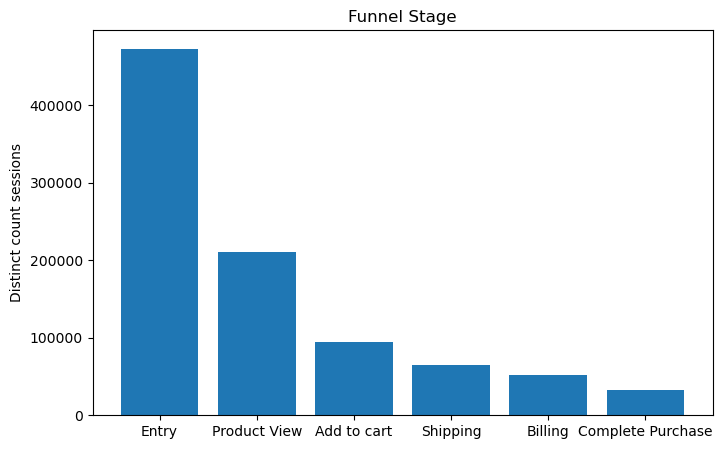

In [192]:
plt.figure(figsize=(8, 5))
plt.bar(funnel_stage.index, funnel_stage.values)
plt.title("Funnel Stage")
plt.ylabel("Distinct count sessions")
plt.show()

Số lượt session qua các bước giảm dần, điều này hợp lý theo hành vi thông thường của User. 
Tiếp tục quan sát theo tỷ lệ chuyển đổi

                             website_session_id
Page type                                      
Conversion rate in total               0.068334
Entry to Product View                  0.444548
Product View to Add to cart            0.451697
Add to cart to Shipping                0.679115
Shipping to Billing                    0.807301
Billing to Complete                    0.620712


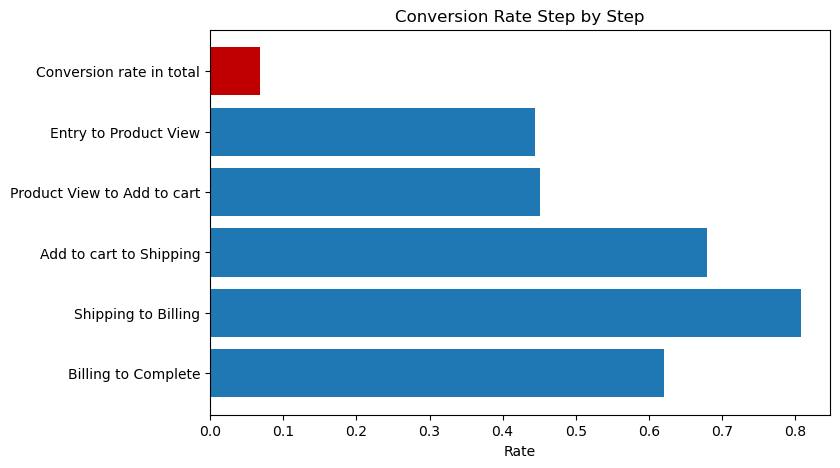

In [224]:
#tính tỷ lệ chuyển đổi qua các bước
conversion_rate = funnel_stage_T[["Conversion rate in total","Entry to Product View","Product View to Add to cart","Add to cart to Shipping","Shipping to Billing","Billing to Complete"]].T
colors = [
    "#C00000" if idx == "Conversion rate in total" else "#1f77b4"
    for idx in conversion_rate.index
]
print(conversion_rate)

plt.figure(figsize=(8, 5))
plt.barh(conversion_rate.index, conversion_rate["website_session_id"], color = colors)
plt.title("Conversion Rate Step by Step")
plt.xlabel("Rate")
plt.gca().invert_yaxis()
plt.show()

Nhận xét:
- Overall conversion rate: 6.83% => tỷ lệ này tương đối tốt với E-commerce
- Entry -> Product: 44.45% => đây là điểm có drop lớn nhất, user chỉ vào entry đọc info chưa có nhu cầu vào xem sản phẩm chi tiết
- Product View -> Add to Cart: 45.12% => đây cũng là điểm có drop lớn, user đã xem sản phẩm như chưa phát sinh nhu cầu mua
- Add to Cart -> Shipping: 68% => tỷ lệ chuyển đổi tốt, phần lớn user cho sản phẩm vào giỏ đã có ý định mua hàng
- Shipping -> Billing: 80.7% => tỷ lệ chuyển đổi tốt, phần lớn user chấp nhận với mức phí ship và quyết định thanh toán
- Billing -> Complete: 62% => đây là điểm drop quan trọng, do user đã thực hiện đến bước thanh toán nhưng 38% user không hoàn thành

Insights:
- Cải thiện landing page để thu hút user vào xem sản phẩm
- Giá, sản phẩm hoặc các thông tin chi tiết về sản phẩm có thể đang chưa thu hút users
- Phân tích tỷ lệ lỗi thanh toán để xác định nguyên nhân user không hoàn thành bước thanh toán
- Các phương thức thanh toán có thể đang chưa đa dạng, thuận tiện

### Bóc tách tỷ lệ chuyển đổi theo thiết bị

In [226]:
#tính số session theo thiết bị
website_pageviews_joined = website_pageviews_2.merge(
    website_sessions[["website_session_id", "device_type", "utm_source", "utm_campaign"]],
    on="website_session_id",
    how="left"
)
funnel_stage_by_device = website_pageviews_joined.groupby(["Page type","device_type"])["website_session_id"].nunique().sort_values(ascending=False)
funnel_stage_by_device

Page type          device_type
Entry              desktop        327027
Product View       desktop        163214
Entry              mobile         145844
Add to cart        desktop         75155
Shipping           desktop         52692
Product View       mobile          47000
Billing            desktop         43722
Complete Purchase  desktop         27805
Add to cart        mobile          19798
Shipping           mobile          11792
Billing            mobile           8336
Complete Purchase  mobile           4508
Name: website_session_id, dtype: int64

device_type        desktop  mobile
Page type                         
Entry               327027  145844
Product View        163214   47000
Add to cart          75155   19798
Shipping             52692   11792
Billing              43722    8336
Complete Purchase    27805    4508


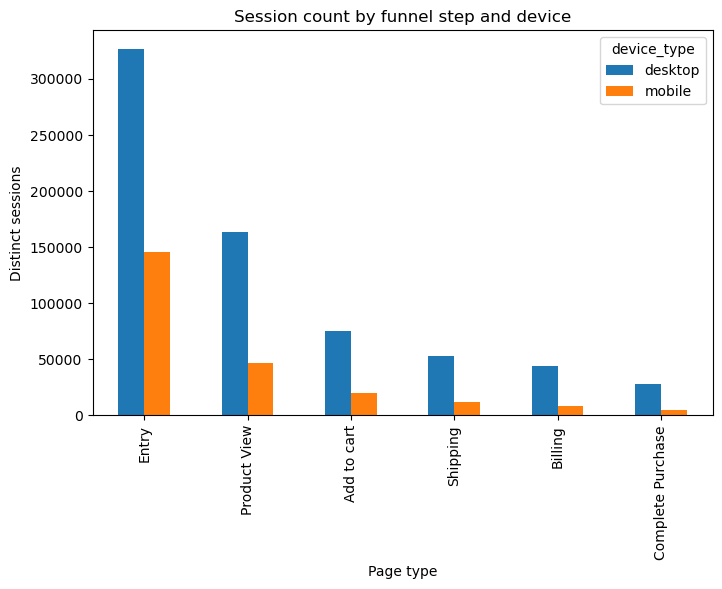

In [195]:
flow_order = ["Entry","Product View","Add to cart","Shipping","Billing","Complete Purchase"]
session_by_device = funnel_stage_by_device.reset_index()
session_by_device["Page type"] = pd.Categorical(
    session_by_device["Page type"],
    categories=flow_order,
    ordered=True
)
session_by_device = session_by_device.pivot(
    index="Page type",
    columns="device_type",
    values="website_session_id"
)
print(session_by_device)
session_by_device.plot(kind="bar", figsize=(8,5))
plt.title("Session count by funnel step and device")
plt.ylabel("Distinct sessions")
plt.show()

Số lượt truy cập vào từ Desktop cao hơn hẳn so với Mobile

device_type                   desktop    mobile
Page type                                      
Conversion rate in total     0.085024  0.030910
Entry to Product View        0.499084  0.322262
Product View to Add to cart  0.460469  0.421234
Add to cart to Shipping      0.701111  0.595616
Shipping to Billing          0.829765  0.706920
Billing to Complete          0.635950  0.540787


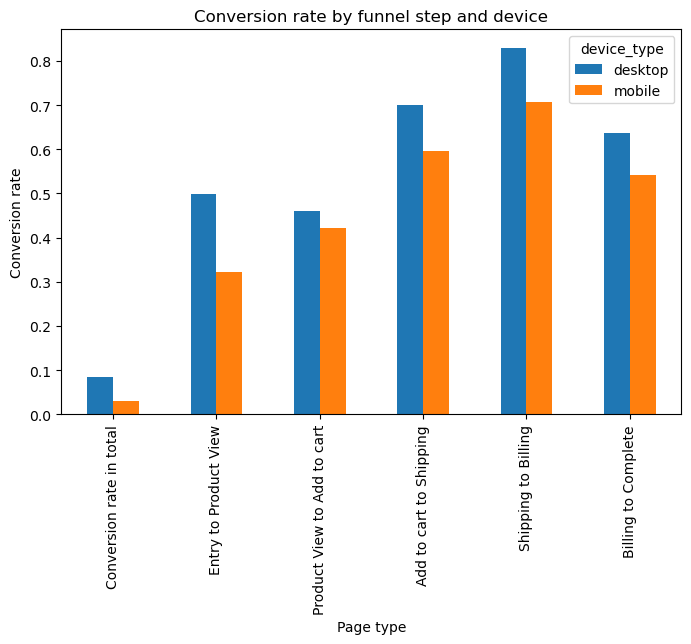

In [228]:
#tính tỷ lệ chuyển đổi theo thiết bị
funnel_stage_by_device_T = funnel_stage_by_device.reset_index().pivot(
    index="device_type",
    columns="Page type",
    values="website_session_id"
)
funnel_stage_by_device_T["Conversion rate in total"] = funnel_stage_by_device_T["Complete Purchase"]/funnel_stage_by_device_T["Entry"]
funnel_stage_by_device_T["Entry to Product View"] = funnel_stage_by_device_T["Product View"]/funnel_stage_by_device_T["Entry"]
funnel_stage_by_device_T["Product View to Add to cart"] = funnel_stage_by_device_T["Add to cart"]/funnel_stage_by_device_T["Product View"]
funnel_stage_by_device_T["Add to cart to Shipping"] = funnel_stage_by_device_T["Shipping"]/funnel_stage_by_device_T["Add to cart"]
funnel_stage_by_device_T["Shipping to Billing"] = funnel_stage_by_device_T["Billing"]/funnel_stage_by_device_T["Shipping"]
funnel_stage_by_device_T["Billing to Complete"] = funnel_stage_by_device_T["Complete Purchase"]/funnel_stage_by_device_T["Billing"]

Cvr_by_device = funnel_stage_by_device_T[["Conversion rate in total","Entry to Product View","Product View to Add to cart","Add to cart to Shipping","Shipping to Billing","Billing to Complete"]].T
print(Cvr_by_device)
Cvr_by_device.plot(kind="bar", figsize=(8,5))
plt.title("Conversion rate by funnel step and device")
plt.ylabel("Conversion rate")
plt.show()

Xét về tỷ lệ chuyển đổi, desktop cũng vượt trội so với Mobile. Tỷ lệ chuyển đổi của Mobile thấp hơn hẳn từ ngay bước Entry -> Product View. Điều này gợi ý rằng UI UX của Mobile có thể đang chưa tốt khiến cho user không muốn tiếp tục tìm hiểu sản phẩm

### Bóc tách tỷ lệ chuyển đổi theo source

utm_source         bsearch  gsearch  socialbook
Page type                                      
Entry                62823   316035       10685
Product View         27261   140620        2053
Add to cart          12476    63376         950
Shipping              8698    42855         652
Billing               7125    34561         535
Complete Purchase     4519    21333         343


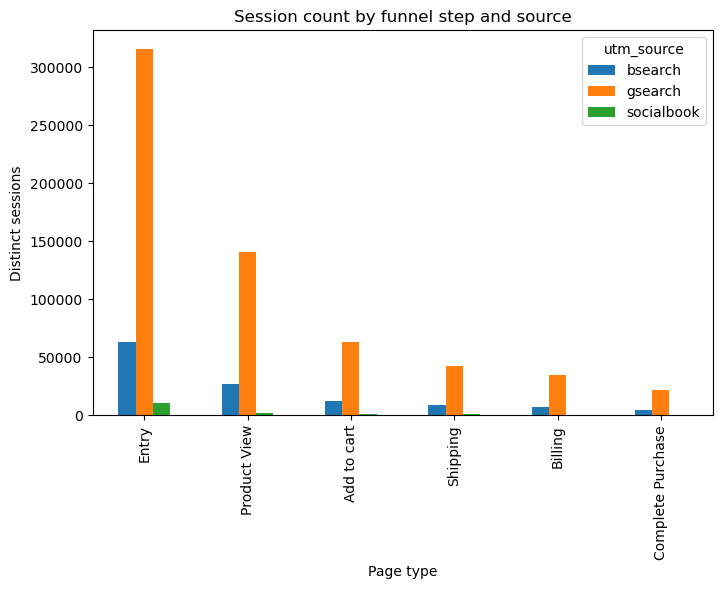

In [231]:
funnel_stage_by_source = website_pageviews_joined.groupby(["Page type","utm_source"])["website_session_id"].nunique().sort_values(ascending=False)
session_by_source = funnel_stage_by_source.reset_index()
session_by_source["Page type"] = pd.Categorical(
    session_by_source["Page type"],
    categories=flow_order,
    ordered=True
)
session_by_source = session_by_source.pivot(
    index="Page type",
    columns="utm_source",
    values="website_session_id"
)
print(session_by_source)
session_by_source.plot(kind="bar", figsize=(8,5))
plt.title("Session count by funnel step and source")
plt.ylabel("Distinct sessions")
plt.show()

utm_source                    bsearch   gsearch  socialbook
Page type                                                  
Conversion rate in total     0.071932  0.067502    0.032101
Entry to Product View        0.433933  0.444951    0.192139
Product View to Add to cart  0.457650  0.450690    0.462737
Add to cart to Shipping      0.697179  0.676202    0.686316
Shipping to Billing          0.819154  0.806464    0.820552
Billing to Complete          0.634246  0.617256    0.641121


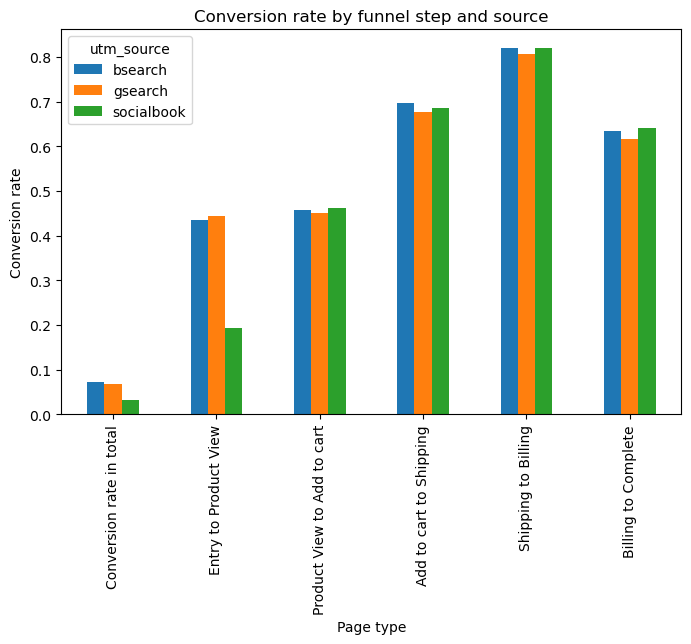

In [233]:
#tính tỷ lệ chuyển đổi theo thiết bị
funnel_stage_by_source_T = funnel_stage_by_source.reset_index().pivot(
    index="utm_source",
    columns="Page type",
    values="website_session_id"
)
funnel_stage_by_source_T["Conversion rate in total"] = funnel_stage_by_source_T["Complete Purchase"]/funnel_stage_by_source_T["Entry"]
funnel_stage_by_source_T["Entry to Product View"] = funnel_stage_by_source_T["Product View"]/funnel_stage_by_source_T["Entry"]
funnel_stage_by_source_T["Product View to Add to cart"] = funnel_stage_by_source_T["Add to cart"]/funnel_stage_by_source_T["Product View"]
funnel_stage_by_source_T["Add to cart to Shipping"] = funnel_stage_by_source_T["Shipping"]/funnel_stage_by_source_T["Add to cart"]
funnel_stage_by_source_T["Shipping to Billing"] = funnel_stage_by_source_T["Billing"]/funnel_stage_by_source_T["Shipping"]
funnel_stage_by_source_T["Billing to Complete"] = funnel_stage_by_source_T["Complete Purchase"]/funnel_stage_by_source_T["Billing"]

Cvr_by_source = funnel_stage_by_source_T[["Conversion rate in total","Entry to Product View","Product View to Add to cart","Add to cart to Shipping","Shipping to Billing","Billing to Complete"]].T
print(Cvr_by_source)
Cvr_by_source.plot(kind="bar", figsize=(8,5))
plt.title("Conversion rate by funnel step and source")
plt.ylabel("Conversion rate")
plt.show()

Social traffic có conversion tổng thấp hơn hẳn bsearch và gsearch chủ yếu do drop mạnh ở Entry -> Product view. 
Tuy nhiên khi user của social đã vào Product, tỷ lệ chuyển đổi ở các bước sau không hề kém bsearch và gsearch, thậm chí cao hơn.
Điều này cho thấy user có tò mò với content từ social và click vào link truy cập website, tuy nhiên đây không phải là tập có nhu cầu mua nên user ngay lập tức rời khỏi website. 

Social vừa có lượt truy cập thấp nhất vừa drop mạnh ở entry, cho thấy chiến lược social chưa được tối ưu cho user có nhu cầu mua hàng. Tuy nhiên, chất lượng user sau khi vào product là tốt, nên vấn đề nằm ở bước targeting, content và landing page.